In [1]:
import pandas as pd
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Lambdas found by EM (with  $\epsilon=0.0001$)

* As expected, when we run EM on *train data*, we get $\lambda_3=1$. 

* This is because this data has the same sequence of words, so the probabilities given by $3-$gram is the highest (or at least it is newer lower than $2-$gram)

In [2]:
df = pd.read_csv("results/cross-ent.csv.params")
df[df["from"]=="train"].round(6)

,dataset,from,l0,l1,l2,l3
0,cz,train,0.0,0.0,0.000024,0.999976
2,en,train,0.0,0.0,0.000023,0.999977


* On the other hand, when we use the *holdout data*, the result is different. Uniform probability is not very probable, which makes sense. 


* We can see that the Czech language has much more weight on $p_1$. Most probably, because the Czech language has a much larger vocabulary and in the *train data*, there are not enough combinations to even correctly model the $p_2$. In the English language, there are fewer words, so probably the $p_2$ gives the best probability. 


* Both languages do not have $\lambda_3$  the highest. I would say that if we had much more good training data, then maybe the $\lambda_3$ would be a bit higher.

In [3]:
df[df["from"]=="holdout"].round(6)

,dataset,from,l0,l1,l2,l3
1,cz,holdout,0.0,0.445858,0.450697,0.103444
3,en,holdout,0.0,0.165022,0.674777,0.160201


# Cross-Entropy on the test data
* First, let's look at the default result (with unmodified $\lambda_3$).
* As stated above, Czech 2-grams and 3-grams are probably not very accurate for a lot of words, so 1-grams have the highest weight. Thus this leads to higher entropy than in the case of English.

In [4]:
df = pd.read_csv("results/cross-ent.csv")# .sort_values(["dataset", "experiment", "mess_prob"], ascending = (True, True, True))
df[df["modif"]=="default"].round(6) # 

,dataset,modif,modif_val,L3_val,cross_entropy
0,cz,default,0.0,0.103444,9.696974
22,en,default,0.0,0.160201,7.032398


## Increasing and decreasing the $\lambda_3$ and and proportionally changing $\lambda_0, \lambda_1, \lambda_2$
* No we will increase and decrease the importance of the $3-$ gram and we will observe how the Cross-Entropy will change.

### Increasing the $\lambda_3$
* In the figure below, we can see the results. We can see that for both languages, the increase of the $\lambda_3$ leads to higher entropy. This is probably caused because oftentimes the $3-$gram does not know the answer producing $1/|V|$ and when most of the weight is on it, we are getting higher entropy. (But if we would perform the experiment on the *train data*, then the entropy would decrease to 0 ...) 

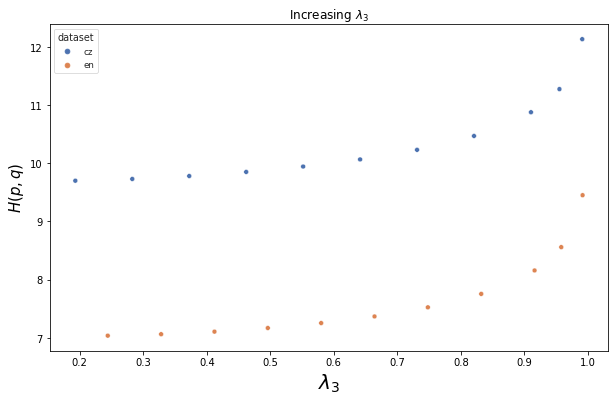

In [5]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.set_title('Increasing $\lambda_3$')
ax1.set_xlabel("$\lambda_3$", fontsize='20')
ax1.set_ylabel("$H(p,q)$", fontsize='15')

sns.set_theme(style="whitegrid")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":13})   
ax = sns.scatterplot(x="L3_val", y="cross_entropy",  hue="dataset", data=df[(df['modif']=="inc")], ax=ax1)

### Decreasing the $\lambda_3$
* On the figure below, we can see the resuts. We can se that for both languages, decreasement of the $\lambda_3$ also leads to higher entropy. 


* This means, that the value assigned to the $3-$gram is probably quite good. We can see, that both icreasement and decreasement of the $\lambda_3$ leads to incresement of cross entropy on the *test data*.


* This would suggest that the EM (using the *holdout data*) found quite optimal values of $\lambda_i$ and it  produces lowest entropy on *test data* also (at least w.r.t. icreasement or decreasement of $\lambda_3$)

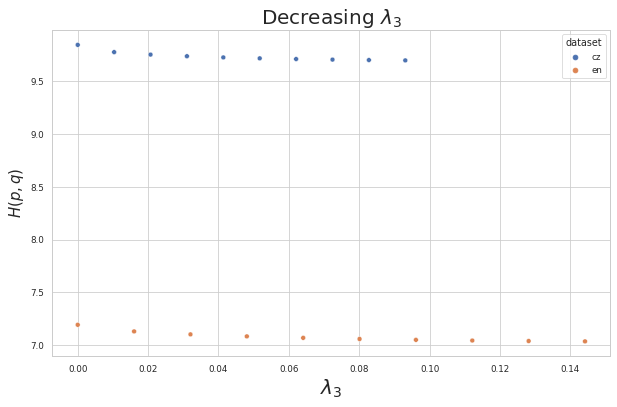

In [6]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.set_title('Decreasing $\lambda_3$')
ax1.set_xlabel("$\lambda_3$", fontsize='20')
ax1.set_ylabel("$H(p,q)$", fontsize='15')

sns.set_theme(style="whitegrid")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":13})   
ax = sns.scatterplot(x="L3_val", y="cross_entropy",  hue="dataset", data=df[(df['modif']=="dec")], ax=ax1)

### Nicely plot of both decreasement and increasement together
* I Smoothed the results and plot it together to see the results better

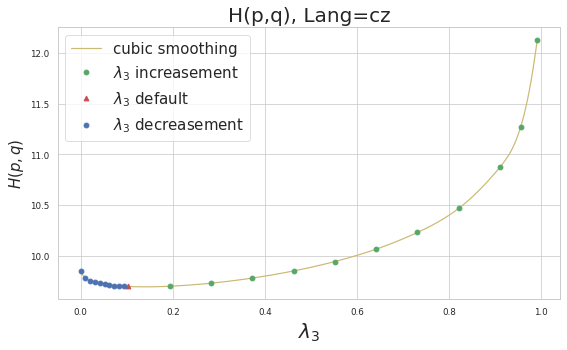

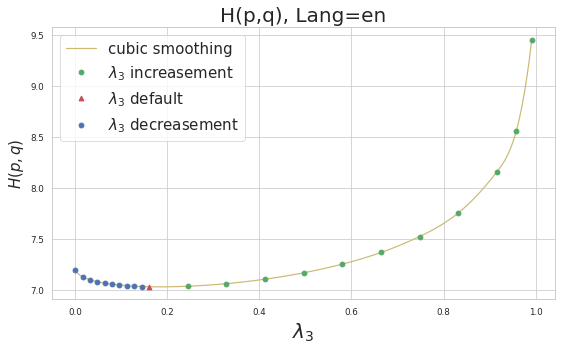

In [8]:
from scipy.interpolate import interp1d


for lang in df['dataset'].unique():
    # print(lang)
    x = np.asarray(df[(df['dataset']==lang)]['L3_val'])
    y = np.asarray(df[(df['dataset']==lang)]['cross_entropy'])
    
    x_def = float(df[(df['dataset']==lang) & (df['modif']=='default')]['L3_val'])
    y_def = float(df[(df['dataset']==lang) & (df['modif']=='default')]['cross_entropy'])
    
    x_dec = np.asarray(df[(df['dataset']==lang) & (df['modif'] == 'dec')]['L3_val'])
    y_dec = np.asarray(df[(df['dataset']==lang) & (df['modif'] == 'dec')]['cross_entropy'])
    
    x_inc = np.asarray(df[(df['dataset']==lang) & (df['modif'] == 'inc')]['L3_val'])
    y_inc = np.asarray(df[(df['dataset']==lang) & (df['modif'] == 'inc')]['cross_entropy'])
    
    f = interp1d(x, y, kind='cubic')  # perform the Cubic Interpolation ...
    xnew = np.linspace(x.min(), x.max(), 300, endpoint=True)
    
    
    fig, ax = plt.subplots(1,1, figsize=(9,5))
#     ax.set_xlim([0,0.6])
#     ax.set_ylim([6,12])

    ax.set_title('H(p,q), Lang={}'.format(lang))
    ax.set_xlabel("$\lambda_3$", fontsize='20')
    ax.set_ylabel("$H(p,q)$", fontsize='15')

    l, = ax.plot(xnew, f(xnew), '-y')
    l.set_label("cubic smoothing")
    
    l, = ax.plot(x_inc, y_inc, 'og')
    l.set_label("$\lambda_3$ increasement")
    
    l, = ax.plot(x_def, y_def, '^r')
    l.set_label("$\lambda_3$ default")
    
    l, = ax.plot(x_dec, y_dec, 'ob')
    l.set_label("$\lambda_3$ decreasement")
    
    
#     l, = ax.plot(xnew[f(xnew).argmin()] ,f(xnew).min(), "or")
#     l.set_label("smoothed min")    
    
    ax.legend(prop={'size': 15})
    plt.show()